In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, Bidirectional, Dropout, LSTM

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [9]:
data = pd.read_csv("/content/drive/MyDrive/Aprendizaje/Practica5/Ejercicio1/Tweets.csv")

In [14]:
X=data['text']
y=data['airline_sentiment']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000

count_vector = CountVectorizer(max_features=vocabulary_size, preprocessor=lambda x: x, tokenizer=lambda x: x)

X_bow = count_vector.fit_transform(X).toarray()


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_bow[0]

array([21,  0,  8,  0,  4,  3, 18,  0,  0,  3,  5,  0,  0,  5,  3,  7, 12,
        5,  0,  6, 13,  5,  5,  3,  1,  1,  5,  0,  0,  0,  0,  0,  0,  0,
        0])

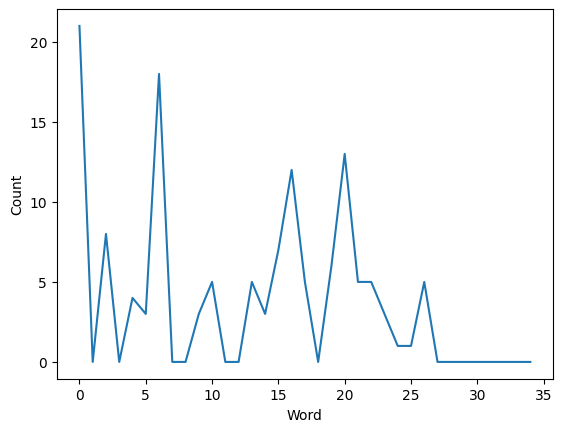

In [ ]:
plt.plot(X_bow[0,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [15]:
maxlen = 100
training_samples = 10000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
sequences = pad_sequences(sequences, maxlen)

In [28]:
sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   81,   62, 6686,
        226], dtype=int32)

In [16]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = to_categorical(encoded_Y)

In [17]:
def clean_train_data(x):
    text = x
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    return text

In [18]:
mes = []
for i in X:
  i=clean_train_data(i)
  mes.append(i.split())

In [19]:
X[0]

'@VirginAmerica What @dhepburn said.'

In [20]:
mes[0]

['virginamerica', 'what', 'dhepburn', 'said']

In [7]:
from gensim.models import Word2Vec

In [22]:
EMBEDDING_DIM = 500
word2vec_model = Word2Vec(mes, vector_size=500, window=3, min_count=1, workers=16)
print(word2vec_model)

Word2Vec<vocab=13280, vector_size=500, alpha=0.025>


In [23]:
embeddings_index = {}
for w in word2vec_model.wv.key_to_index.keys():
    embeddings_index[w] = word2vec_model.wv[w]

In [24]:
embedding_weights = np.zeros((len(tokenizer.word_index)+1, 500))
for word, index in tokenizer.word_index.items():
    embedding_weights[index,:] = embeddings_index[word] if word in embeddings_index else np.random.rand(500)
    index += 1
print(embedding_weights.shape)

(15769, 500)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(np.array(sequences), dummy_y, test_size=0.2, stratify=y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(11712, 100) (2928, 100) (11712, 3) (2928, 3)


In [32]:
model = Sequential()
model.add(Embedding(embedding_weights.shape[0], embedding_weights.shape[1], weights=[embedding_weights], input_length=maxlen, trainable=False))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x_train, y_train, batch_size=16, epochs=15, validation_data=(x_test, y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 500)          7884500   
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 32)           48032     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               164864    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                